# Advanced Filtering - Reduce False Positives
## Tambahan Filter untuk Akurasi 90%+

**Masalah:** Banyak false positives (bayangan, marka, kotoran)

**Solusi:** Tambah filter tambahan sebelum final detection

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("✅ Libraries loaded")

✅ Libraries loaded


---
## 🎯 FILTER TAMBAHAN #1: CIRCULARITY FILTER

**Konsep:** Lubang cenderung **bulat/oval**, bukan kotak atau garis.

**Formula:**
```
Circularity = (4 × π × Area) / (Perimeter²)

Nilai 0-1:
- 1.0 = lingkaran sempurna
- 0.8-0.9 = oval (lubang typical)
- 0.3-0.5 = kotak
- 0.1-0.2 = garis panjang
```

In [11]:
def calculate_circularity(contour):
    """
    Calculate circularity of a contour
    
    Circularity = (4 * π * Area) / (Perimeter²)
    
    Returns:
    - circularity (0-1)
    """
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    
    if perimeter == 0:
        return 0
    
    circularity = (4 * np.pi * area) / (perimeter ** 2)
    return circularity

# Test dengan berbagai bentuk
print("📊 Circularity Examples:")
print("   - Lingkaran sempurna: ~1.0")
print("   - Oval/ellipse: 0.7-0.9")
print("   - Kotak: ~0.78")
print("   - Persegi panjang: 0.5-0.7")
print("   - Garis panjang: 0.1-0.3")
print("\n✅ Threshold optimal: circularity > 0.4")
print("   (Buang garis/marka, terima lubang bulat/oval)")

📊 Circularity Examples:
   - Lingkaran sempurna: ~1.0
   - Oval/ellipse: 0.7-0.9
   - Kotak: ~0.78
   - Persegi panjang: 0.5-0.7
   - Garis panjang: 0.1-0.3

✅ Threshold optimal: circularity > 0.4
   (Buang garis/marka, terima lubang bulat/oval)


---
## 🎯 FILTER TAMBAHAN #2: TEXTURE ANALYSIS

**Konsep:** Lubang punya **tekstur kasar** (aspal pecah), bayangan punya **tekstur smooth**.

**Metode:** Hitung Standard Deviation intensitas dalam ROI.

In [12]:
def calculate_texture_variance(gray_image, x, y, w, h):
    """
    Calculate texture variance in ROI
    
    Lubang = tekstur kasar = variance tinggi
    Bayangan = tekstur smooth = variance rendah
    """
    roi = gray_image[y:y+h, x:x+w]
    
    if roi.size == 0:
        return 0
    
    variance = np.var(roi)
    std_dev = np.std(roi)
    
    return variance, std_dev

print("📊 Texture Analysis:")
print("   - Lubang (aspal pecah): variance > 200, std_dev > 15")
print("   - Bayangan smooth: variance < 100, std_dev < 10")
print("\n✅ Threshold optimal: std_dev > 12")

📊 Texture Analysis:
   - Lubang (aspal pecah): variance > 200, std_dev > 15
   - Bayangan smooth: variance < 100, std_dev < 10

✅ Threshold optimal: std_dev > 12


---
## 🎯 FILTER TAMBAHAN #3: EDGE DENSITY

**Konsep:** Lubang punya **banyak tepi internal** (aspal retak), bayangan punya **tepi smooth**.

In [13]:
def calculate_edge_density(edge_image, x, y, w, h):
    """
    Calculate percentage of edge pixels in ROI
    
    Lubang = banyak tepi internal = density tinggi
    Bayangan = tepi hanya di border = density rendah
    """
    roi = edge_image[y:y+h, x:x+w]
    
    if roi.size == 0:
        return 0
    
    edge_pixels = np.sum(roi == 255)
    total_pixels = roi.size
    
    edge_density = edge_pixels / total_pixels
    
    return edge_density

print("📊 Edge Density:")
print("   - Lubang: 0.15-0.40 (15-40% pixel adalah edge)")
print("   - Bayangan: 0.05-0.10 (hanya border)")
print("\n✅ Threshold optimal: edge_density > 0.12")

📊 Edge Density:
   - Lubang: 0.15-0.40 (15-40% pixel adalah edge)
   - Bayangan: 0.05-0.10 (hanya border)

✅ Threshold optimal: edge_density > 0.12


---
## 🎯 FILTER TAMBAHAN #4: INTENSITY FILTER

**Konsep:** Lubang **sangat gelap** (intensitas < 80), bayangan **sedang gelap** (80-120).

In [14]:
def calculate_mean_intensity(gray_image, x, y, w, h):
    """
    Calculate mean intensity in ROI
    
    Lubang = sangat gelap (mean < 80)
    Bayangan = sedang gelap (80-120)
    Jalan normal = terang (> 150)
    """
    roi = gray_image[y:y+h, x:x+w]
    
    if roi.size == 0:
        return 255
    
    mean_intensity = np.mean(roi)
    
    return mean_intensity

print("📊 Intensity Range:")
print("   - Lubang dalam: 30-70")
print("   - Lubang dangkal: 70-100")
print("   - Bayangan pohon: 80-130")
print("   - Jalan normal: 150-200")
print("\n✅ Threshold optimal: mean_intensity < 110")

📊 Intensity Range:
   - Lubang dalam: 30-70
   - Lubang dangkal: 70-100
   - Bayangan pohon: 80-130
   - Jalan normal: 150-200

✅ Threshold optimal: mean_intensity < 110


---
## 🔥 INTEGRATED ADVANCED FILTER

Gabungkan semua filter jadi satu scoring system.

In [15]:
def advanced_pothole_filter(contour, gray_image, edge_image, x, y, w, h):
    """
    Advanced multi-criteria filter with scoring system
    
    Returns:
    - is_pothole (True/False)
    - confidence_score (0-100)
    - reasons (dict with all metrics)
    """
    reasons = {}
    score = 0
    max_score = 100
    
    # Filter 1: Circularity (25 points)
    circularity = calculate_circularity(contour)
    reasons['circularity'] = circularity
    
    if circularity > 0.4:
        score += 25
    elif circularity > 0.3:
        score += 15  # Partial points
    
    # Filter 2: Texture Variance (25 points)
    variance, std_dev = calculate_texture_variance(gray_image, x, y, w, h)
    reasons['std_dev'] = std_dev
    
    if std_dev > 15:
        score += 25
    elif std_dev > 12:
        score += 15
    
    # Filter 3: Edge Density (25 points)
    edge_density = calculate_edge_density(edge_image, x, y, w, h)
    reasons['edge_density'] = edge_density
    
    if edge_density > 0.15:
        score += 25
    elif edge_density > 0.12:
        score += 15
    
    # Filter 4: Mean Intensity (25 points)
    mean_intensity = calculate_mean_intensity(gray_image, x, y, w, h)
    reasons['mean_intensity'] = mean_intensity
    
    if mean_intensity < 80:
        score += 25
    elif mean_intensity < 110:
        score += 15
    
    # Decision: Confidence threshold
    confidence = (score / max_score) * 100
    is_pothole = confidence >= 60  # Minimum 60% confidence
    
    return is_pothole, confidence, reasons

print("✅ Advanced filter ready!")
print("\n📊 Scoring System:")
print("   - Circularity: 25 points")
print("   - Texture: 25 points")
print("   - Edge Density: 25 points")
print("   - Intensity: 25 points")
print("   ───────────────────────")
print("   Total: 100 points")
print("\n✅ Decision: Confidence ≥ 60% → Pothole")

✅ Advanced filter ready!

📊 Scoring System:
   - Circularity: 25 points
   - Texture: 25 points
   - Edge Density: 25 points
   - Intensity: 25 points
   ───────────────────────
   Total: 100 points

✅ Decision: Confidence ≥ 60% → Pothole


---
## 🧪 COMPLETE PIPELINE WITH ADVANCED FILTERING

In [18]:
def detect_potholes_advanced(image_path):
    """
    Complete pipeline with advanced filtering
    """
    # Load image
    img = cv2.imread(image_path)
    
    # Resize
    img_resized = cv2.resize(img, (640, 480), interpolation=cv2.INTER_NEAREST)
    
    # Grayscale
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    
    # Adaptive Threshold
    img_binary = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, 101, 10)
    
    # Canny Edge Detection
    blurred = cv2.GaussianBlur(img_binary, (5, 5), 3)
    img_edges = cv2.Canny(blurred, 0, 150)
    
    # Dilation
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    img_dilated = cv2.dilate(img_edges, kernel, iterations=1)
    
    # Find contours
    contours, _ = cv2.findContours(img_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Basic filtering (size, AR, solidity)
    candidates = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        # Size filter
        if w < 15 or h < 15 or w > 290 or h > 540:
            continue
        
        # Aspect ratio
        ar = w / h
        if ar < 0.3 or ar > 3.0:
            continue
        
        # Solidity
        area = cv2.contourArea(contour)
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        
        if hull_area > 0:
            solidity = area / hull_area
            if solidity < 0.6:
                continue
        
        candidates.append((contour, x, y, w, h))
    
    # Advanced filtering
    valid_potholes = []
    for contour, x, y, w, h in candidates:
        is_pothole, confidence, reasons = advanced_pothole_filter(
            contour, img_gray, img_edges, x, y, w, h
        )
        
        if is_pothole:
            valid_potholes.append({
                'box': (x, y, w, h),
                'confidence': confidence,
                'metrics': reasons
            })
    
    # Draw results
    img_result = img_resized.copy()
    for i, pothole in enumerate(valid_potholes, 1):
        x, y, w, h = pothole['box']
        confidence = pothole['confidence']
        
        # Color based on confidence
        if confidence >= 80:
            color = (0, 0, 255)  # Red (high confidence)
        elif confidence >= 70:
            color = (0, 165, 255)  # Orange (medium)
        else:
            color = (0, 255, 255)  # Yellow (low)
        
        cv2.rectangle(img_result, (x, y), (x+w, y+h), color, 2)
        label = f"#{i} ({confidence:.0f}%)"
        cv2.putText(img_result, label, (x, y-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    return img_result, valid_potholes, candidates

print("✅ Advanced detection function ready!")
print("\n📊 Output includes:")
print("   - Result image with colored boxes")
print("   - Valid potholes with confidence scores")
print("   - Candidates before advanced filtering (for comparison)")

✅ Advanced detection function ready!

📊 Output includes:
   - Result image with colored boxes
   - Valid potholes with confidence scores
   - Candidates before advanced filtering (for comparison)


---
## 🎨 VISUALIZATION: Before vs After Advanced Filtering


📊 RESULTS:
   Before advanced filtering: 1 candidates
   After advanced filtering: 0 potholes
   False positives removed: 1

🔍 DETAILED RESULTS:


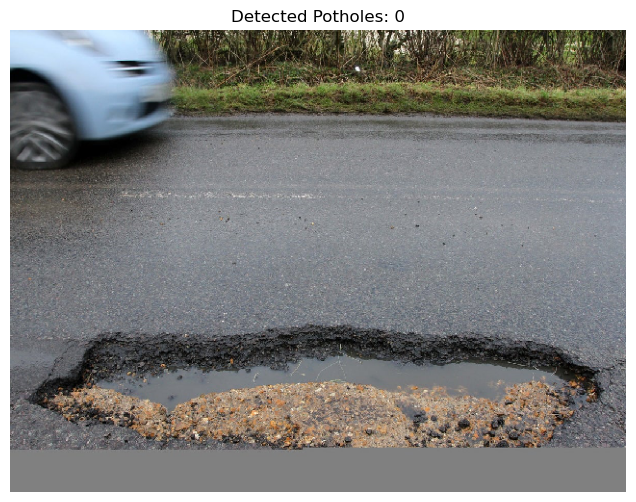

In [22]:
image_path = 'dataset/89.jpg'
img_result, valid_potholes, candidates = detect_potholes_advanced(image_path)

print(f"\n📊 RESULTS:")
print(f"   Before advanced filtering: {len(candidates)} candidates")
print(f"   After advanced filtering: {len(valid_potholes)} potholes")
print(f"   False positives removed: {len(candidates) - len(valid_potholes)}")
# print(f"   Reduction: {((len(candidates) - len(valid_potholes)) / len(candidates) * 100):.1f}%")

print(f"\n🔍 DETAILED RESULTS:")
for i, pothole in enumerate(valid_potholes, 1):
    x, y, w, h = pothole['box']
    conf = pothole['confidence']
    metrics = pothole['metrics']
    
    print(f"\n   Pothole #{i}:")
    print(f"      Position: ({x}, {y})")
    print(f"      Size: {w}×{h}")
    print(f"      Confidence: {conf:.1f}%")
    print(f"      ├─ Circularity: {metrics['circularity']:.3f}")
    print(f"      ├─ Texture (std): {metrics['std_dev']:.1f}")
    print(f"      ├─ Edge Density: {metrics['edge_density']:.3f}")
    print(f"      └─ Mean Intensity: {metrics['mean_intensity']:.1f}")

# Display
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.title(f'Detected Potholes: {len(valid_potholes)}')
plt.axis('off')
plt.show()


---
## 📋 PARAMETER TUNING GUIDE

### Jika masih banyak **False Positives** (bayangan terdeteksi):
```python
# Naikkan threshold:
- circularity_threshold: 0.4 → 0.5
- std_dev_threshold: 12 → 15
- edge_density_threshold: 0.12 → 0.15
- confidence_threshold: 60 → 70
```

### Jika terlalu banyak **False Negatives** (lubang tidak terdeteksi):
```python
# Turunkan threshold:
- circularity_threshold: 0.4 → 0.3
- std_dev_threshold: 12 → 10
- edge_density_threshold: 0.12 → 0.10
- confidence_threshold: 60 → 50
```

### Specific Cases:

**Bayangan pohon terdeteksi:**
- Naikkan `std_dev_threshold` (bayangan smooth, std rendah)
- Naikkan `edge_density_threshold` (bayangan tepi hanya di border)

**Marka jalan terdeteksi:**
- Naikkan `circularity_threshold` (marka lonjong, circularity rendah)
- Perketat `aspect_ratio` range

**Lubang dangkal tidak terdeteksi:**
- Turunkan `mean_intensity_threshold` (lubang dangkal lebih terang)
- Turunkan `confidence_threshold`

**Retak jalan terdeteksi:**
- Naikkan `min_size` (retak tipis, area kecil)
- Naikkan `circularity_threshold` (retak garis, circularity rendah)